# Modeling

In [52]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

In [65]:
# load data
# data with feature selection and without adding features
path_1 = '/Users/yutingmei/Projects/APlusBernstein-Project/data/processed/weight/dt_processed_weight_0.csv'
df1 = pd.read_csv(path_1)

path_2 = '/Users/yutingmei/Projects/APlusBernstein-Project/data/processed/weight/feature/dt_processed_weight_feature_1.csv'
df2 = pd.read_csv(path_2)

path = '/Users/yutingmei/Projects/APlusBernstein-Project/data/raw/FactorTimingData-ABVU2022.xlsx'
target = pd.read_excel(path, sheet_name = 'target')

#### train test split

In [66]:
# the first row can't be filled
df1 = df1.iloc[1:-1,:]
df2 = df2.iloc[:-1, :]

In [67]:
y = target.iloc[1:, -3]

In [68]:
df1['y'] = target.iloc[1:, -3]
df2['y'] = target.iloc[1:, -3]

In [69]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)
df2 = scaler.fit_transform(df2)

In [35]:
test_size = 1000

X_train1 = df1[:-test_size]
X_test1 = df1[-test_size:]

X_train2 = df2[:-test_size]
X_test2 = df2[-test_size:]

In [36]:
y_train1 = y[:-test_size]
y_test1 = y[-test_size:]

y_train2 = y[:-test_size]
y_test2 = y[-test_size:]

#### baseline model

In [8]:
# baseline model
# make predictions with most frequency
def daseline(X_train, X_test, y_train, y_test):
    clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    #Distribution of y test
    print('y actual : \n' +  str(y_test.value_counts()))
    #Distribution of y predicted
    print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))
    print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(y_test,y_pred)))

In [9]:
daseline(X_train1, X_test1, y_train1, y_test1)

y actual : 
1    555
0    506
Name: sc_1d_fwd_rel_d, dtype: int64
y predicted : 
1    1061
dtype: int64
Accuracy Score : 0.5230914231856739
Precision Score : 0.5230914231856739
Recall Score : 1.0
F1 Score : 0.6868811881188118


In [9]:
daseline(X_train2, X_test2, y_train2, y_test2)

y actual : 
1    552
0    509
Name: sc_1d_fwd_rel_d, dtype: int64
y predicted : 
1    1061
dtype: int64
Accuracy Score : 0.5202639019792649
Precision Score : 0.5202639019792649
Recall Score : 1.0
F1 Score : 0.6844389336639801


#### logistic regression

In [11]:
def grid_proc(param_grid, model, X_train, X_test, y_train, y_test):
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    gs = GridSearchCV(estimator=model,
                 param_grid = param_grid,
                 scoring = 'balanced_accuracy',
                 cv= cv,
                 n_jobs =-1,
                refit=True)
    gs = gs.fit(X_train, y_train)
    gs_p = gs.predict(X_test)
    gs_df= pd.DataFrame(gs.cv_results_)
    return gs, gs_p, gs_df

In [12]:
model1 = LogisticRegression()
params1 = {'l1_ratio':np.linspace(0.1,0.9,15),
           # 'l2_ratio':np.linspace(0,1,10),
               'C': np.logspace(-2, 1, 20),
              'solver':['saga'],
              'tol':[0.05, 0.01,  0.02, 0.05, 0.075, 0.1],
          'penalty':['elasticnet'],
          'max_iter':[150, 200, 250]}

In [15]:
grid_search_log1, log_predict1, results_log1 = grid_proc(param_grid = params1, 
                         model = model1, X_train = X_train1, X_test = X_test1, 
                         y_train = y_train1, y_test = y_test1)

In [21]:
model2 = LogisticRegression()
params2 = {'l1_ratio':np.linspace(0.3,1,15),
               'C': np.logspace(0, 2, 20),
              'solver':['saga'],
              'tol':[0.05,  0.01, 0.025, 0.05, 0.75, 0.1],
          'penalty':['elasticnet'],
          'max_iter':[150, 200, 250]}

In [23]:
grid_search_log2, log_predict2, results_log2 = grid_proc(param_grid = params2, 
                         model = model2, X_train = X_train2, X_test = X_test2, 
                         y_train = y_train2, y_test = y_test2)

In [22]:
grid_search_log1.best_estimator_

LogisticRegression(C=1.623776739188721, l1_ratio=0.1, max_iter=200,
                   penalty='elasticnet', solver='saga', tol=0.1)

In [24]:
grid_search_log2.best_estimator_

LogisticRegression(C=8.858667904100825, l1_ratio=0.8499999999999999,
                   max_iter=150, penalty='elasticnet', solver='saga', tol=0.75)

##### regression matrix

In [17]:
def regre_matrix(y_test, y_pred):
    rmse = lambda act, pred: np.sqrt(mean_squared_error(act, pred))
    # Error metrics
    print(f'RMSE: {rmse(y_test, y_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')

In [18]:
regre_matrix(y_test1, log_predict1)

RMSE: 0.7028513356322231
MAPE: 828662331436171.5


In [25]:
regre_matrix(y_test2, log_predict2)

RMSE: 0.7042726744663603
MAPE: 1319554690819555.2


##### confusion matrix

In [19]:
def get_metric(y_test, y_pred, model):
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
    accu = metrics.accuracy_score(y_test, y_pred)
    print(report)
    print("Accuracy:",accu)
    disp.plot()
    plt.show()

              precision    recall  f1-score   support

           0       0.52      0.65      0.58       523
           1       0.48      0.35      0.40       477

    accuracy                           0.51      1000
   macro avg       0.50      0.50      0.49      1000
weighted avg       0.50      0.51      0.49      1000

Accuracy: 0.506


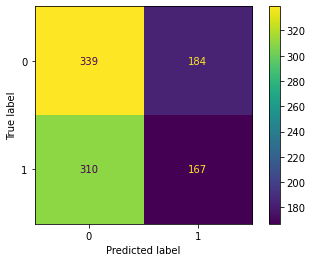

In [20]:
# bad performance using logistic regression
get_metric(y_test1, log_predict1, grid_search_log1)

              precision    recall  f1-score   support

           0       0.53      0.44      0.48       523
           1       0.48      0.57      0.52       477

    accuracy                           0.50      1000
   macro avg       0.51      0.51      0.50      1000
weighted avg       0.51      0.50      0.50      1000

Accuracy: 0.504


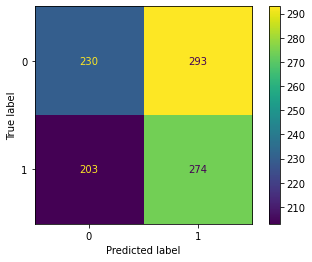

In [26]:
get_metric(y_test2, log_predict2, grid_search_log2)